In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import time

import notebook_style
labels = notebook_style.labels

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1D-Heat-transfer-(implicit-solution)" data-toc-modified-id="1D-Heat-transfer-(implicit-solution)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>1D Heat transfer (implicit solution)</a></span><ul class="toc-item"><li><span><a href="#Implicit-Formulation" data-toc-modified-id="Implicit-Formulation-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Implicit Formulation</a></span></li><li><span><a href="#Insert-boundary-conditions" data-toc-modified-id="Insert-boundary-conditions-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Insert boundary conditions</a></span></li></ul></li></ul></div>

# 1D Heat transfer (implicit solution)

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2020_

    Code under MIT license, all other material under CC-BY-3.0 license

> This notebook is strongly inspired by the notebooks of the online course _["Practical Numerical Methods with Python"](https://github.com/numerical-mooc/numerical-mooc/) by Lorena A. Barba et al_

In [lesson 05](/05%20-%201D%20Heat%20transfer%20heterogenous.ipynb) we developed the finite difference solution for the onedimensional heterogenous heat equation:

\begin{align}
T^{n+1}_{i}
= \frac{\Delta t}{\Delta x^2} \left( \frac{\alpha_{i} + \alpha_{i+1}}{2} \left( T^n_{i+1} - T^n_i \right) - \frac{\alpha_{i-1} + \alpha_{i}}{2} \left(T^n_{i} - T^n_{i-1} \right) \right) + T^n_i + s^n_{i}
\end{align}

Here the temperature of the next time step $T^{n+1}_{i}$ depends on three values of the present time step $T^{n}_{i-1}$, $T^{n}_{i}$ and $T^{n}_{i+1}$. 

Which is the forward or _explicit_ finite difference method. For this method the Courant-Friedrichs-Lewy (CFL) stability criterion had to be fulfilled to remain numerically stable:

$$
\sigma = \alpha \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
$$

$$
 \Delta t  \leq \frac{\Delta x^2}{2 \alpha}
$$

This criterion can lead to very costly computations for larger and detailed models. 

## Implicit Formulation

A numerically _"unconditionally"_ stable scheme is the _implicit_ finite difference method. Here the spatial derivative is formulated depending on the next time step: 

\begin{align}
T^{n+1}_{i}
= \frac{\Delta t}{\Delta x^2} \left( \frac{\alpha_{i} + \alpha_{i+1}}{2} \left( T^{n+1}_{i+1} - T^{n+1}_i \right) - \frac{\alpha_{i-1} + \alpha_{i}}{2} \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right) \right) + T^n_i + \Delta t \cdot s^n_{i}
\end{align}

We substitute:

$$
\sigma = \frac{\alpha\Delta t}{\Delta x^2}
$$


\begin{align}
T^{n+1}_{i}
= \frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n+1}_{i+1} - T^{n+1}_i \right) - \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right)  + T^n_i + \Delta t \cdot s^n_{i}
\end{align}

Which is an equation with three unknowns, which we bring to the left hand side and the known temperature to the right hand side:

\begin{align}
T^{n+1}_{i}
= \frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n+1}_{i+1} - T^{n+1}_i \right) - \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right)  + \Delta t \cdot T^n_i + \Delta t \cdot s^n_{i}
\end{align}

\begin{align}
\left(\frac{-\sigma_{i} - \sigma_{i+1}}{2} \right) T^{n+1}_{i-1} + 
\left(1 + \frac{\sigma_{i} + \sigma_{i+1}}{2} + \frac{\sigma_{i-1} + \sigma_{i}}{2} \right) T^{n+1}_{i} + 
\left( \frac{-\sigma_{i} - \sigma_{i+1}}{2} \right) T^{n+1}_{i+1}
&= T^n_i + \Delta t \cdot s^n_{i} \\
%
\left(\frac{-\sigma_{i} - \sigma_{i+1}}{2} \right) T^{n+1}_{i-1} + 
\left(1 + \sigma_{i} + \frac{\sigma_{i-1} + \sigma_{i+1}}{2} \right) T^{n+1}_{i} + 
\left( \frac{-\sigma_{i} - \sigma_{i+1}}{2} \right) T^{n+1}_{i+1}
&= T^n_i + \Delta t \cdot s^n_{i} \\
%
\left(-\sigma_{i} - \sigma_{i+1} \right) T^{n+1}_{i-1} + 
\left(2 + 2 \sigma_{i} + \sigma_{i-1} + \sigma_{i+1} \right) T^{n+1}_{i} + 
\left( -\sigma_{i} - \sigma_{i+1} \right) T^{n+1}_{i+1}
&= 2 T^n_i + 2 \Delta t \cdot s^n_{i}
\end{align}

Taking the same example from lesson 04 we look at a small model of 5 elements with a fixed temperature on the left side and no heat flux in the right side:

<img src="./figures/heat 1d model 02.png" width="400"/>


We can formulate three of these equations, where we still have a total of two unknown temperatures:

\begin{align}
\left(-\sigma_{1} - \sigma_{2} \right) T^{n+1}_{0} + 
\left(2 + 2 \sigma_{1} + \sigma_{0} + \sigma_{2} \right) T^{n+1}_{1} + 
\left( -\sigma_{1} - \sigma_{2} \right) T^{n+1}_{2}
&= 2 T^n_1 \\
\left(-\sigma_{2} - \sigma_{3} \right) T^{n+1}_{1} + 
\left(2 + 2 \sigma_{2} + \sigma_{1} + \sigma_{3} \right) T^{n+1}_{2} + 
\left( -\sigma_{2} - \sigma_{3} \right) T^{n+1}_{3}
&= 2 T^n_2 \\
\left(-\sigma_{3} - \sigma_{4} \right) T^{n+1}_{2} + 
\left(2 + 2 \sigma_{3} + \sigma_{2} + \sigma_{4} \right) T^{n+1}_{3} + 
\left( -\sigma_{3} - \sigma_{4} \right) T^{n+1}_{4}
&= 2 T^n_3 
\end{align}

## Insert boundary conditions

Dirichlet BC on left side (fixed temperature $T_0$): 

$$
T_{0}^{n+1} = 100 ^\circ C
$$

\begin{align}
\left(2 + 2 \sigma_{1} + \sigma_{0} + \sigma_{2} \right) T^{n+1}_{1} + 
\left( -\sigma_{1} - \sigma_{2} \right) T^{n+1}_{2}
&= 2 T^n_1 + \left(\sigma_{1} + \sigma_{2} \right) T^{n+1}_{0} \\
&= 2 T^n_1 + \left(\sigma_{1} + \sigma_{2} \right) 100 ^\circ C
\end{align}

Neumann BC on right side (no heat flux):

\begin{align}
T_{4}^{n+1} &= T_{3}^{n+1} + u(t) \Delta x & \\
T_{4}^{n+1} &= T_{3}^{n+1} & \mathrm{with} \; u(t) = 0
\end{align}

\begin{align}
\left(-\sigma_{3} - \sigma_{4} \right) T^{n+1}_{2} + 
\left(2 + 2 \sigma_{3} + \sigma_{2} + \sigma_{4} \right) T^{n+1}_{3} + 
\left( -\sigma_{3} - \sigma_{4} \right) T^{n+1}_{4}
&= 2 T^n_3 \\
\left(-\sigma_{3} - \sigma_{4} \right) T^{n+1}_{2} + 
\left(2 + 2 \sigma_{3} + \sigma_{2} + \sigma_{4} \right) T^{n+1}_{3} + 
\left( -\sigma_{3} - \sigma_{4} \right) T^{n+1}_{3}
&= 2 T^n_3 \\
\left(-\sigma_{3} - \sigma_{4} \right) T^{n+1}_{2} + 
\left(2 + \sigma_{3} + \sigma_{2} \right) T^{n+1}_{3}
&= 2 T^n_3 
\end{align}

We have __3 unknowns and 3 equations! :__

\begin{align} 
\left(2 + 2 \sigma_{1} + \sigma_{0} + \sigma_{2} \right) T^{n+1}_{1} + 
\left( -\sigma_{1} - \sigma_{2} \right) T^{n+1}_{2}
&= 2 T^n_1 + \left(\sigma_{1} + \sigma_{2} \right) 100 ^\circ C \\
\left(-\sigma_{2} - \sigma_{3} \right) T^{n+1}_{1} + 
\left(2 + 2 \sigma_{2} + \sigma_{1} + \sigma_{3} \right) T^{n+1}_{2} + 
\left( -\sigma_{2} - \sigma_{3} \right) T^{n+1}_{3}
&= 2 T^n_2 \\
\left(-\sigma_{3} - \sigma_{4} \right) T^{n+1}_{2} + 
\left(2 + \sigma_{3} + \sigma_{2} \right) T^{n+1}_{3}
&= 2 T^n_3 
\end{align}

We can put this system of equations into matrix form:

$$
[A][x] = [b]+[b]_{b.c.}
$$

With $[x]$ with the temperatures we want to calculate, $[b]$ the temperatures of the current time step and $[b]_{b.c.}$ the boundary conditions. Matrix $[A]$ specifies the relations between the tempertures in our model. 

$$
\begin{align}
    \left[
        \begin{array}{ccc}
            2 + 2 \sigma_{1} + \sigma_{0} + \sigma_{2} & -\sigma_{1} - \sigma_{2} & 0  \\
            -\sigma_{2} - \sigma_{3} & 2 + 2 \sigma_{2} + \sigma_{1} + \sigma_{3} & -\sigma_{2} - \sigma_{3} \\
             0 & -\sigma_{3} - \sigma_{4} & 2 + \sigma_{3} + \sigma_{2}
        \end{array}
    \right] \cdot 
    \left[
        \begin{array}{c} 
            T_1^{n+1} \\
            T_2^{n+1} \\           
            T_3^{n+1}
        \end{array}
    \right] =
    2 \cdot \left[
        \begin{array}{c} 
            T_1^n  \\
            T_2^n \\
            T_3^n 
        \end{array}
    \right] +
    \begin{bmatrix}
        \left(\sigma_{1} + \sigma_{2} \right) 100 ^\circ C\\
        0 \\
        0
    \end{bmatrix}
\end{align}
$$

We build again our model:

In [2]:
# explicit model
def explicit1D_nofluxright(T, sigma):
    T[1:-1] += sigma[1:] * (T[2:] - T[1:-1]) - sigma[:-1] * (T[1:-1] - T[:-2])
    # no heat flux on right side
    T[-1] = T[-2]
    return T

In [3]:
def calc_A_matrix(sigma):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    Nx = len(sigma)
    A_size = (Nx - 2)
    # Setup the diagonal of the operator.
    D = sigma[2:] + sigma[:-2] + 2 * sigma[1:-1] + 2
    # Setup the Neumann condition for the last element.
    D[-1] -= sigma[-2] + sigma[-1]
    # Setup the upper diagonal of the operator.
    U = -(sigma[1:-1] + sigma[2:])[:-1]
    # Setup the lower diagonal of the operator.
    L = -(sigma[:-2] + sigma[1:-1])[1:]
    # Assemble the operator.
    A = sparse.diags(diagonals=[D, U, L],
                 offsets=[0, 1, -1], shape=(A_size, A_size),
                 format="csr")
    return A
def calc_b_vector(T, sigma, udx=0):
    """
    Compute vector b + b_bc for 1D model with dirichlet BC on left and 
    Neumann BC (heat flux udx) on right side
    """
    b = 2*T[1:-1] 
    # Set Dirichlet condition.
    b[0] += T[0] * (sigma[0] + sigma[1])
    # Set Neumann condition.
    b[-1] += udx
    return b
def implicit1D_nofluxright(T, sigma, A):
    """
    Solve implicit matrix formulation, pass matrix A (only calculate once)
    """
    # Generate the right-hand side of the system.
    b = calc_b_vector(T, sigma, 0)
    # Solve the system with spssolve from scipy.sparse.linalg 
    T[1:-1] = spsolve(A, b)
    # Apply the Neumann boundary condition.
    T[-1] = T[-2] 
    return T

In [4]:
d = 40 / 1000
Nx = 51
dx = d / (Nx - 1)
print(f"dx = {dx} mm")
x = np.arange(Nx) * dx

alpha = 1e-5 * np.ones(Nx)
alpha[Nx//3:-Nx//3] *= 5

dt_CLF = dx**2 / 2 / np.max(alpha)
print(f"limit for numerical stability (explicit scheme): dt = {dt_CLF: .4f} s")

# try larger and smaller time steps
dt_explicit = dt_CLF / 4

print(f"used time step (explicit scheme): dt = {dt_explicit: .4f} s")

dt_factor = 2**6

dt_implicit = dt_explicit * dt_factor
print(f"used time step (implicit scheme): dt = {dt_implicit: .4f} s")

print(f"dt_implicit / dt_explicit = {dt_factor: .1f}")
print(f"dt_implicit / dt_CLF = {dt_implicit / dt_CLF: .1f}")

T = np.zeros(Nx)
T[0] = 100

dx = 0.0008 mm
limit for numerical stability (explicit scheme): dt =  0.0064 s
used time step (explicit scheme): dt =  0.0016 s
used time step (implicit scheme): dt =  0.1024 s
dt_implicit / dt_explicit =  64.0
dt_implicit / dt_CLF =  16.0


<IPython.core.display.Javascript object>


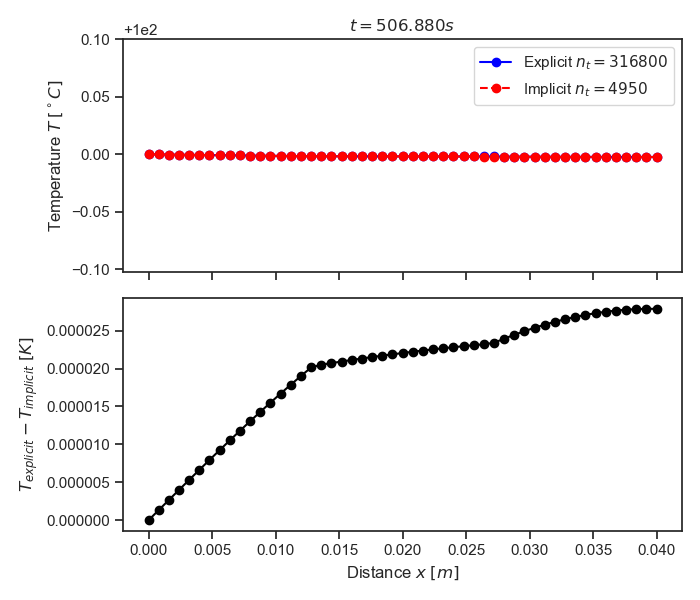

Explicit calculation took  1.46835 s
Implicit calculation took  0.28741 s


In [5]:
# number of time steps to compute
nt = 5000  
# update plots after how many iterations
i_snap = nt // 100

alpha_mean = (alpha[1:] + alpha[:-1])/2
sigma_explicit = alpha_mean * dt_explicit / dx**2
sigma_implicit = alpha * dt_implicit / dx**2

T1 = np.copy(T)
T2 = np.copy(T)
A = calc_A_matrix(sigma_implicit)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7.0, 6.0))
ax1, ax2 = ax
plt.ion()
calc_time_explicit = 0
calc_time_implicit = 0
for i in range(nt):        
    t0 = time.time()
    for ii in range(dt_factor):
        T1 = explicit1D_nofluxright(T1, sigma_explicit)
    calc_time_explicit += time.time() - t0
    t0 = time.time()
    T2 = implicit1D_nofluxright(T2, sigma_implicit, A)
    calc_time_implicit += time.time() - t0
    
    if i % i_snap == 0:
        plt.sca(ax1)
        plt.cla()
        plt.title(r"$t = %.3f s$" %(i*dt_implicit) )        
        plt.ylabel(r'Temperature $T \; [^\circ C]$')
        plt.plot(x, T1, "o-", color="b", 
                 label=r"Explicit $n_t = %d$" %(i*dt_factor))
        plt.plot(x, T2, "o--", color="r", 
                 label=r"Implicit $n_t = %d$" %(i))
        plt.legend()
        
        plt.sca(ax2)
        plt.cla()
        plt.ylabel(r'$T_{explicit} - T_{implicit} \; [K]$')
        plt.plot(x, T1-T2, "o-", color="k")
        plt.xlabel(r'Distance $x \; [m]$')
        
        ax1.set_ylim(
            (np.min([T1.min(), T2.min()])-.1,
             np.max([T1.max(), T2.max()])+.1)
                     )
        
        plt.tight_layout()
        fig.canvas.flush_events()
        fig.canvas.draw()    
        plt.pause(.2);
print(f"Explicit calculation took {calc_time_explicit: .5f} s")
print(f"Implicit calculation took {calc_time_implicit: .5f} s")